In [0]:
cfrom google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 450kB 41.0MB/s 
     |████████████████████████████████| 3.8MB 35.2MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled googl

In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
import tensorflow.keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1UjYCIcwhKc7n2cIpz5AX1LRgJ2rtRZkl' # The shareable link

In [0]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1UjYCIcwhKc7n2cIpz5AX1LRgJ2rtRZkl


In [0]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy']) #change acc to accuracy
   axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy']) #val_acc to val_accuracy
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
   axs[0].legend(['train', 'val'], loc='best')  
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'val'], loc='best')
   plt.show()

In [0]:
os.chdir('/content/drive/My Drive/ProjectDA')

In [0]:
# base_skin_dir = os.path.join('..', 'input')
base_skin_dir = 'Segmented_Images'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

seg_imageid_path_dict = {os.path.splitext(os.path.basename(x))[0][:-4]: x
                     for x in glob(os.path.join(base_skin_dir,'*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [0]:
os.chdir('/content/drive/My Drive/ProjectDA/DatasetImages')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('HAM10000_metadata.csv')

skin_df = pd.read_csv('HAM10000_metadata.csv')

# Creating New Columns for better readability

# skin_df['path'] = skin_df['image_id'].map(seg_imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [0]:
len(seg_imageid_path_dict)

4103

In [0]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


In [0]:
skin_df.count()

lesion_id        10015
image_id         10015
dx               10015
dx_type          10015
age               9958
sex              10015
localization     10015
cell_type        10015
cell_type_idx    10015
dtype: int64

In [0]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

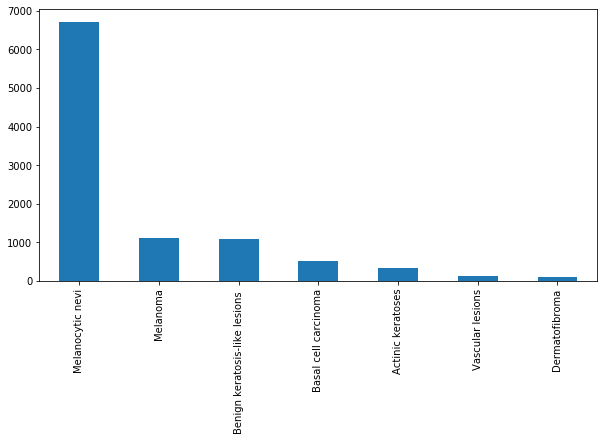

In [0]:
# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [0]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

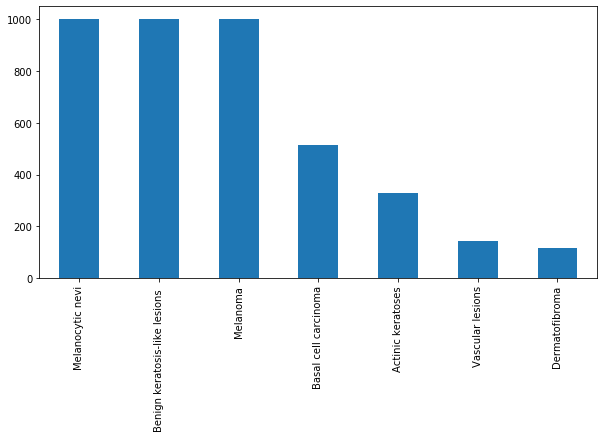

In [0]:
# Too many melanocytic nevi - let's balance it a bit!

skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 4].iloc[:5705].index)
skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 2].iloc[:99].index)
skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 5].iloc[:113].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [0]:
skin_df['path'] = skin_df['image_id'].map(seg_imageid_path_dict.get)

In [0]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
100,HAM_0002957,ISIC_0025876,bkl,histo,70.0,male,back,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0025876...
101,HAM_0002985,ISIC_0025063,bkl,histo,85.0,male,face,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0025063...
102,HAM_0003326,ISIC_0032463,bkl,histo,75.0,male,lower extremity,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0032463...
103,HAM_0003326,ISIC_0025548,bkl,histo,75.0,male,lower extremity,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0025548...
104,HAM_0001853,ISIC_0032306,bkl,histo,55.0,male,face,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0032306...


In [0]:
skin_df.count()

lesion_id        4098
image_id         4098
dx               4098
dx_type          4098
age              4098
sex              4098
localization     4098
cell_type        4098
cell_type_idx    4098
path             4098
dtype: int64

In [0]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type        0
cell_type_idx    0
path             0
dtype: int64

In [0]:
!pwd

/content/drive/My Drive/ProjectDA/DatasetImages


In [0]:
os.chdir('/content/drive/My Drive/ProjectDA')

In [0]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [0]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
100,HAM_0002957,ISIC_0025876,bkl,histo,70.0,male,back,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0025876...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
101,HAM_0002985,ISIC_0025063,bkl,histo,85.0,male,face,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0025063...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
102,HAM_0003326,ISIC_0032463,bkl,histo,75.0,male,lower extremity,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0032463...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
103,HAM_0003326,ISIC_0025548,bkl,histo,75.0,male,lower extremity,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0025548...,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
104,HAM_0001853,ISIC_0032306,bkl,histo,55.0,male,face,Benign keratosis-like lesions,2,Segmented_Images/Segmented_Images/ISIC_0032306...,"[[[116, 84, 97], [127, 106, 115], [255, 240, 2..."


In [0]:
# Checking the image size distribution
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    4098
Name: image, dtype: int64

In [0]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [0]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state = 13)

In [0]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [0]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 13)

In [0]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [0]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

In [0]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',  #change to val_accuracy
                                           patience=3, 
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001) 

In [0]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [0]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
from datetime import datetime
import pytz
tz_NY = pytz.timezone('America/New_York') 
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

Epoch 1/50
295/295 [==============================] - 19s 65ms/step - loss: 1.6846 - accuracy: 0.3088 - val_loss: 1.5453 - val_accuracy: 0.4421
Epoch 2/50
295/295 [==============================] - 15s 52ms/step - loss: 1.5845 - accuracy: 0.3566 - val_loss: 1.4560 - val_accuracy: 0.4482
Epoch 3/50
295/295 [==============================] - 16s 53ms/step - loss: 1.5450 - accuracy: 0.3851 - val_loss: 1.4130 - val_accuracy: 0.4299
Epoch 4/50
295/295 [==============================] - 16s 53ms/step - loss: 1.4882 - accuracy: 0.4061 - val_loss: 1.4127 - val_accuracy: 0.4543
Epoch 5/50
295/295 [==============================] - 16s 53ms/step - loss: 1.4499 - accuracy: 0.4180 - val_loss: 1.3044 - val_accuracy: 0.4878
Epoch 6/50
295/295 [==============================] - 15s 52ms/step - loss: 1.4356 - accuracy: 0.4427 - val_loss: 1.3047 - val_accuracy: 0.4756
Epoch 7/50
295/295 [==============================] - 16s 53ms/step - loss: 1.4231 - accuracy: 0.4356 - val_loss: 1.3135 - val_accuracy:

In [0]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

820/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

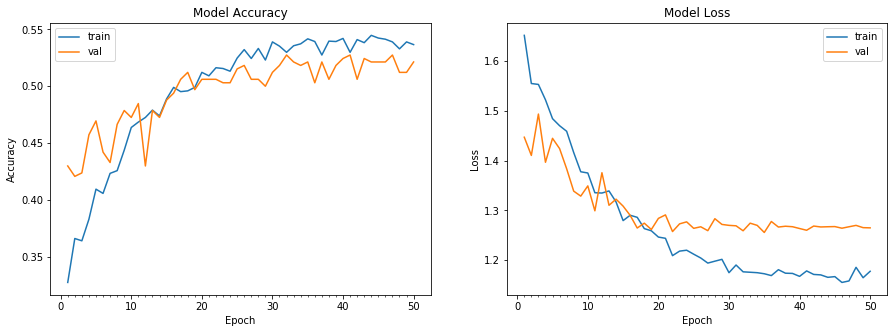

In [0]:
plot_model_history(history)

CONFUSION MATRIX VALIDATE

              precision    recall  f1-score   support

           0       0.56      0.17      0.26        30
           1       0.72      0.53      0.61        49
           2       0.38      0.84      0.52        75
           3       0.00      0.00      0.00         4
           4       0.56      0.47      0.51        78
           5       0.71      0.37      0.49        86
           6       0.80      0.67      0.73         6

    accuracy                           0.51       328
   macro avg       0.53      0.44      0.45       328
weighted avg       0.58      0.51      0.50       328



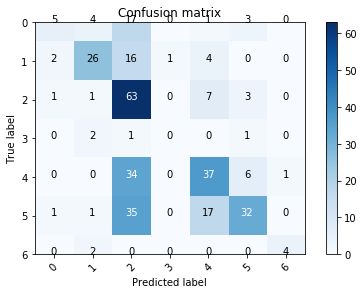

In [0]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)

   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

CONFUSION MATRIX TEST

              precision    recall  f1-score   support

           0       0.38      0.28      0.32        58
           1       0.52      0.48      0.50        97
           2       0.42      0.76      0.54       213
           3       1.00      0.04      0.08        24
           4       0.72      0.56      0.63       194
           5       0.57      0.33      0.42       211
           6       0.62      0.65      0.64        23

    accuracy                           0.51       820
   macro avg       0.61      0.44      0.45       820
weighted avg       0.56      0.51      0.50       820



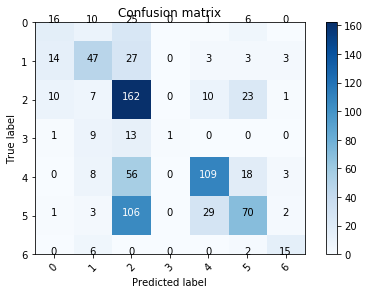

In [0]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)

   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

Text(0, 0.5, 'Fraction classified incorrectly')

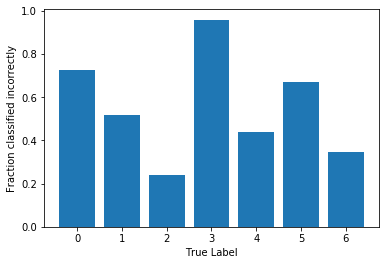

In [0]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

RESNET50

In [0]:
from tensorflow.keras.applications import ResNet50
input_shape = (75, 100, 3)
num_classes = 7

base_model= ResNet50(include_top=False, weights="imagenet", input_shape=(75, 100, 3))
res_model = Sequential()
res_model.add(base_model)
res_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same'))
res_model.add(Dropout(0.40))
res_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same'))
res_model.add(MaxPool2D(pool_size = (2, 2)))
res_model.add(Dropout(0.40))
res_model.add(Flatten())
res_model.add(Dense(512,activation='relu'))
res_model.add(Dropout(0.4))
res_model.add(Dense(7, activation='softmax'))
res_model.summary()

94773248/94765736 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 4, 2048)        23587712  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 4, 64)          1179712   
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 2, 64)          0         
_______________________________________________________

In [0]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [0]:
res_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',  #change to val_accuracy
                                           patience=3, 
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001) 

In [0]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [0]:
# Fit the model
epochs = 50
batch_size = 10
res_history = res_model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
from datetime import datetime
import pytz
tz_NY = pytz.timezone('America/New_York') 
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

Epoch 1/50
295/295 [==============================] - 102s 346ms/step - loss: 1.8704 - accuracy: 0.2824 - val_loss: 1.7203 - val_accuracy: 0.2287
Epoch 2/50
295/295 [==============================] - 100s 340ms/step - loss: 1.6881 - accuracy: 0.3173 - val_loss: 1.6394 - val_accuracy: 0.2957
Epoch 3/50
295/295 [==============================] - 100s 339ms/step - loss: 1.6541 - accuracy: 0.3559 - val_loss: 1.5426 - val_accuracy: 0.3415
Epoch 4/50
295/295 [==============================] - 98s 333ms/step - loss: 1.6137 - accuracy: 0.3729 - val_loss: 1.4672 - val_accuracy: 0.4360
Epoch 5/50
295/295 [==============================] - 98s 331ms/step - loss: 1.5923 - accuracy: 0.3878 - val_loss: 1.4991 - val_accuracy: 0.3811
Epoch 6/50
295/295 [==============================] - 98s 334ms/step - loss: 1.5907 - accuracy: 0.3647 - val_loss: 1.8446 - val_accuracy: 0.3232
Epoch 7/50
294/295 [============================>.] - ETA: 0s - loss: 1.5344 - accuracy: 0.3840
Epoch 00007: ReduceLROnPlateau 

In [0]:
loss, accuracy = res_model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = res_model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
res_model.save("model.h5")

820/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

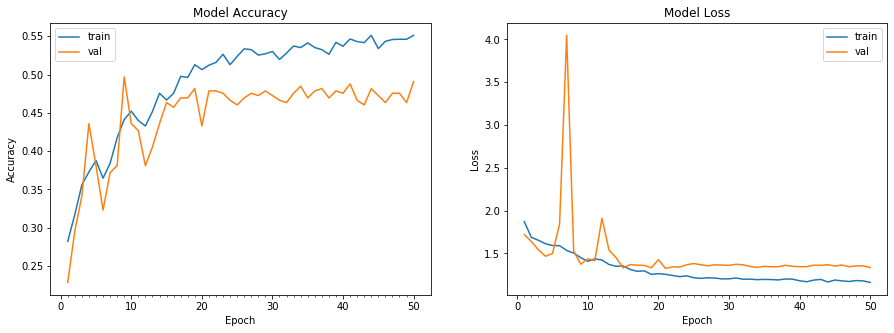

In [0]:
plot_model_history(res_history)

Confusion Matrix Validate

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.76      0.39      0.51        49
           2       0.39      0.71      0.50        75
           3       0.00      0.00      0.00         4
           4       0.59      0.42      0.49        78
           5       0.51      0.60      0.55        86
           6       0.57      0.67      0.62         6

    accuracy                           0.49       328
   macro avg       0.40      0.40      0.38       328
weighted avg       0.49      0.49      0.46       328



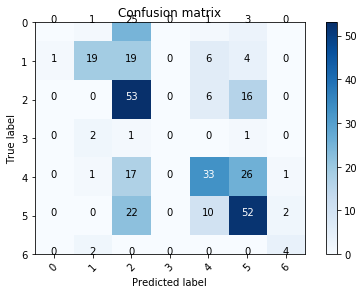

In [0]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)

   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = res_model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

Confusion Matrix test

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.32      0.10      0.16        58
           1       0.61      0.42      0.50        97
           2       0.44      0.61      0.51       213
           3       0.00      0.00      0.00        24
           4       0.63      0.50      0.56       194
           5       0.52      0.64      0.57       211
           6       0.67      0.78      0.72        23

    accuracy                           0.52       820
   macro avg       0.46      0.44      0.43       820
weighted avg       0.51      0.52      0.50       820



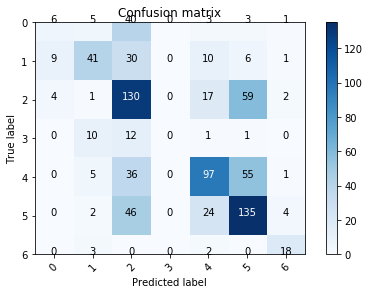

In [0]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)

   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
     plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
    
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = res_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))